# Training and Testing

In [1]:
import numpy as np
import os
import constants as cs
import globali as gg
import settings
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import custom_data_generator as cdg 

### Load configuration data

In [2]:
# Load actions and counters
gg.actions, gg.counters = settings.read_yaml_fields()
label_map = {label:num for num, label in enumerate(gg.actions)}

### Read keypoints and split train and test set

In [3]:
sequences, labels = [], []

# get all the keypoints
for action in tqdm(gg.actions, desc="Processing Actions"):
    for sequence in range(gg.counters[action]):
        window = []
        for frame_num in range(cs.NUM_FRAME):
            res = np.load(os.path.join(cs.KEYPOINTS_FOLDER, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

display(np.array(sequences).shape)   
display(np.array(labels).shape)

Processing Actions: 100%|██████████| 58/58 [01:44<00:00,  1.81s/it]


(4921, 30, 1662)

(4921,)

In [4]:
# generate X and y
X = np.array(sequences)
y = to_categorical(labels).astype(int)

display(X.shape)
display(y.shape)

(4921, 30, 1662)

(4921, 58)

In [5]:
# split training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4428, 30, 1662)

(493, 30, 1662)

(4428, 58)

(493, 58)

### Folders

In [8]:
def create_folder_for_training(number):
    # create folders
    log_f = os.path.join(cs.LOGS_FOLDER, 'log_' + str(number), '')
    model_f = os.path.join(cs.MODELS_FOLDER, 'model_' + str(number))
    os.makedirs(log_f, exist_ok=True)
    os.makedirs(model_f, exist_ok=True)
    log_f = "D:\logs"
    return log_f, model_f

In [9]:
log_f, model_f = create_folder_for_training(31)

### Logs

In [10]:
# log
tensorboard_callback = TensorBoard(log_dir=log_f, histogram_freq=1)
training_log = os.path.join(log_f, 'train_log.csv')
csv_logger = CSVLogger(training_log, append=True)

### Models

In [12]:
# LSTM (model_1)

np_actions = np.array(list(gg.actions))
print(np_actions.shape[0])
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(np_actions.shape[0], activation='softmax'))


58


In [14]:
# LSTM (model_31)
np_actions = np.array(list(gg.actions))
print(np_actions.shape[0])
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(np_actions.shape[0], activation='softmax'))

58


In [12]:
# GRU (model_2)

np_actions = np.array(list(gg.actions))
print(np_actions.shape[0])
model = Sequential()
model.add(GRU(64, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(Dropout(0.2))
model.add(GRU(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False, activation='tanh'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(np_actions.shape[0], activation='softmax'))


58


In [18]:
# GRU (model_31)

np_actions = np.array(list(gg.actions))
model = Sequential()
model.add(GRU(64, return_sequences=True, activation='tanh', input_shape=(30, 1662)))
model.add(GRU(128, return_sequences=True, activation='tanh'))
model.add(GRU(64, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(np_actions.shape[0], activation='softmax'))

In [14]:
# Old LSTM

np_actions = np.array(list(gg.actions))
print(np_actions.shape[0])
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(np_actions.shape[0], activation='softmax'))

58


### Training

In [12]:
# Creazione del generatore personalizzato
batch_size = 32
train_generator = cdg.CustomDataGenerator(X_train, y_train, batch_size=batch_size, augment_data=True)

In [13]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
best_model_path = os.path.join(model_f, 'best_model.h5') 
checkpoint = ModelCheckpoint(best_model_path, monitor='loss', save_best_only=True)
history = model.fit(train_generator, epochs=400, callbacks=[early_stopping,
                                                              checkpoint,
                                                              csv_logger,
                                                              tensorboard_callback])
# save best model
final_model_path = os.path.join(model_f, 'final_model.h5')
model.save(final_model_path)


Epoch 1/400
139/139 [==============================] - ETA: 0s - loss: 4.5524 - categorical_accuracy: 0.0176

C:\Users\Paolo\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


139/139 [==============================] - 41s 154ms/step - loss: 4.5524 - categorical_accuracy: 0.0176
Epoch 2/400
139/139 [==============================] - 22s 156ms/step - loss: 4.0916 - categorical_accuracy: 0.0154
Epoch 3/400
139/139 [==============================] - 22s 154ms/step - loss: 3.9456 - categorical_accuracy: 0.0291
Epoch 4/400
139/139 [==============================] - 21s 151ms/step - loss: 3.8428 - categorical_accuracy: 0.0325
Epoch 5/400
139/139 [==============================] - 21s 154ms/step - loss: 3.8136 - categorical_accuracy: 0.0330
Epoch 6/400
139/139 [==============================] - 21s 148ms/step - loss: 3.6889 - categorical_accuracy: 0.0445
Epoch 7/400
139/139 [==============================] - 20s 146ms/step - loss: 3.6212 - categorical_accuracy: 0.0562
Epoch 8/400
139/139 [==============================] - 20s 141ms/step - loss: 3.5339 - categorical_accuracy: 0.0748
Epoch 9/400
139/139 [==============================] - 20s 142ms/step - loss: 3.4689

KeyboardInterrupt: 

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 58)                1914      
                                                                 
Total params: 598490 (2.28 MB)
Trainable params: 59849

In [16]:
# Load the weights pf trained model
model.load_weights('models/model_31/best_model.h5')

### Evaluation using Confusion Matrix and Accuracy

In [17]:
y_pred = model.predict(X_test)

16/16 [==============================] - 4s 57ms/step


In [18]:
np_actions[np.argmax(y_pred[10])]

'm'

In [19]:
np_actions[np.argmax(y_test[10])]

'nove'

In [20]:
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(y_pred, axis=1).tolist()

In [21]:
print(y_true)

[50, 57, 10, 47, 40, 41, 0, 43, 11, 30, 8, 54, 1, 8, 2, 25, 43, 38, 23, 47, 6, 30, 30, 6, 10, 57, 17, 57, 54, 52, 40, 2, 34, 2, 26, 10, 37, 14, 40, 26, 26, 54, 12, 14, 12, 56, 57, 34, 4, 46, 12, 11, 55, 51, 42, 2, 30, 31, 35, 53, 16, 1, 43, 40, 41, 16, 7, 54, 31, 13, 53, 21, 11, 25, 2, 16, 8, 31, 22, 17, 52, 16, 32, 1, 48, 21, 30, 38, 43, 37, 3, 15, 54, 45, 45, 16, 38, 5, 48, 24, 14, 50, 32, 29, 22, 19, 28, 34, 54, 1, 57, 50, 12, 42, 14, 20, 11, 46, 22, 56, 26, 20, 51, 33, 23, 25, 31, 33, 16, 7, 23, 36, 19, 4, 33, 34, 17, 25, 43, 19, 26, 3, 21, 55, 26, 56, 27, 50, 0, 28, 9, 56, 34, 18, 29, 6, 11, 33, 49, 13, 57, 33, 6, 34, 22, 17, 50, 13, 7, 14, 46, 48, 47, 51, 20, 28, 22, 25, 37, 3, 6, 52, 7, 7, 40, 0, 18, 33, 21, 53, 56, 37, 20, 36, 45, 17, 22, 4, 10, 27, 9, 45, 31, 41, 17, 11, 50, 13, 32, 52, 3, 16, 21, 41, 16, 10, 48, 3, 51, 56, 38, 31, 41, 47, 52, 6, 34, 17, 50, 24, 47, 49, 18, 24, 29, 8, 20, 22, 53, 4, 29, 27, 45, 28, 47, 2, 19, 3, 24, 49, 37, 43, 36, 34, 47, 14, 35, 1, 7, 40, 51

In [22]:
print(y_pred)

[4, 50, 2, 47, 51, 41, 55, 43, 11, 30, 47, 54, 1, 8, 2, 25, 14, 46, 23, 10, 6, 30, 24, 6, 10, 57, 17, 57, 54, 52, 40, 2, 34, 2, 26, 10, 37, 14, 40, 26, 26, 54, 12, 14, 12, 56, 57, 34, 4, 28, 12, 4, 28, 51, 42, 2, 30, 31, 35, 53, 16, 1, 43, 40, 17, 16, 7, 54, 31, 13, 1, 21, 11, 25, 2, 16, 21, 31, 14, 17, 52, 16, 32, 2, 48, 21, 34, 38, 43, 48, 3, 15, 36, 45, 45, 16, 38, 0, 48, 2, 14, 50, 32, 29, 22, 43, 28, 34, 50, 2, 57, 36, 12, 1, 22, 20, 11, 46, 22, 56, 7, 22, 51, 33, 52, 25, 31, 33, 16, 7, 23, 13, 19, 4, 33, 19, 17, 34, 25, 30, 26, 3, 21, 12, 26, 56, 27, 50, 0, 28, 9, 54, 34, 18, 29, 6, 11, 33, 49, 13, 57, 33, 6, 34, 22, 17, 50, 56, 7, 14, 46, 48, 10, 51, 20, 28, 22, 43, 37, 3, 6, 52, 7, 7, 21, 0, 35, 33, 21, 53, 56, 37, 20, 13, 25, 17, 20, 4, 47, 27, 9, 45, 31, 41, 17, 11, 50, 13, 32, 52, 3, 16, 4, 41, 16, 10, 48, 3, 51, 22, 28, 31, 41, 47, 52, 6, 34, 17, 50, 24, 51, 49, 18, 24, 29, 8, 20, 22, 53, 4, 29, 27, 45, 57, 47, 2, 19, 3, 11, 49, 19, 43, 13, 34, 16, 14, 18, 27, 7, 40, 3, 9, 

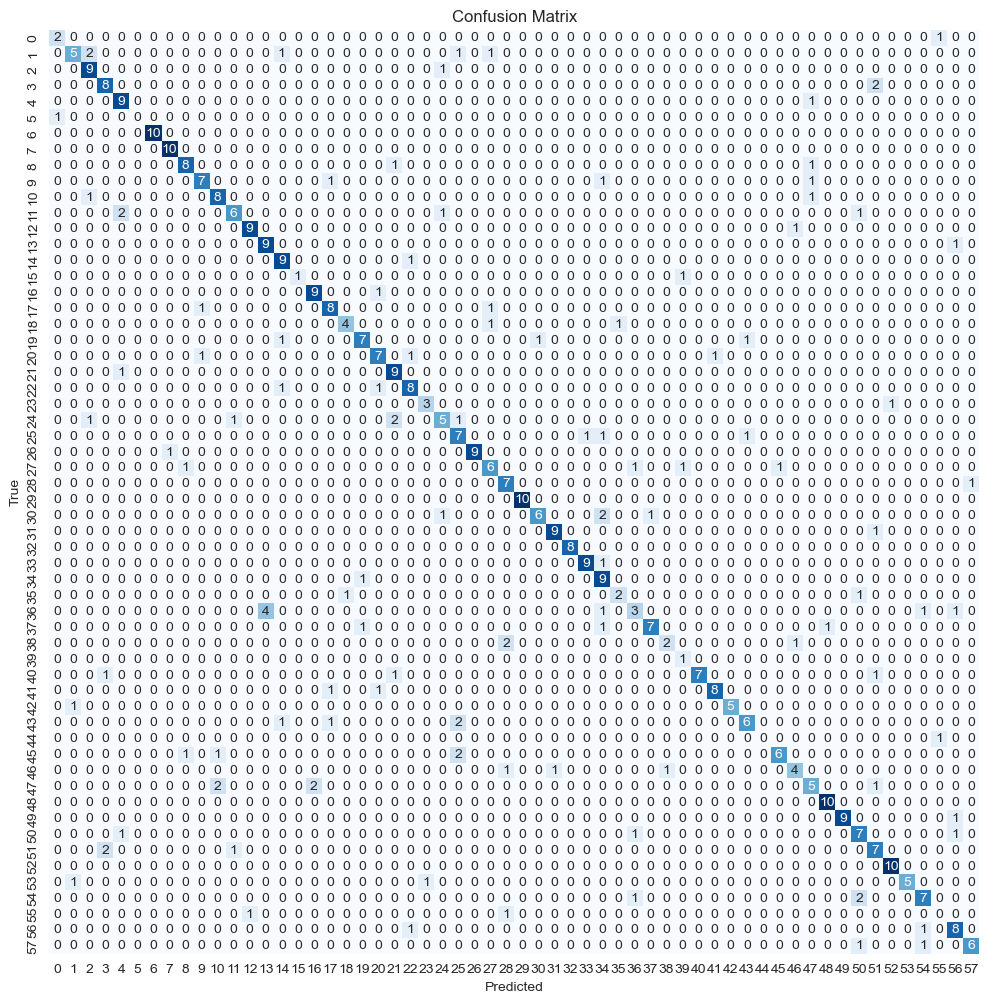

In [23]:
# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# show confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# save confusion matrix into file JPG
plt.savefig(model_f + '/confusion_matrix.jpg', format='jpg')
plt.show()
plt.close()

In [24]:
accuracy_score(y_true, y_pred)

0.7606490872210954